In [1]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import random
from tqdm import tqdm
from utils import plot_tsne
import glob

for model_file in glob.glob('*.pth'):
    os.remove(model_file)
    print(f"Removed saved model: {model_file}")

# Set constants
NUM_CLASSES = 10
LATENT_DIM = 128
BATCH_SIZE = 64
EPOCHS = 40  # Single training process, might need more epochs
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
SEED = 43

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
freeze_seeds(SEED)

Using device: cpu


In [2]:
# Cell 2: Define the Encoder - Using the same architecture as in 1.2.1
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        """
        Encoder network for classification-guided training.
        
        Args:
            in_channels: Number of input channels (1 for MNIST, 3 for CIFAR10)
            latent_dim: Dimension of the latent space (128 as per requirements)
        """
        super(Encoder, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Calculate the size of the flattened features
        if in_channels == 1:  # MNIST
            self.fc_input_size = 128 * 4 * 4
        else:  # CIFAR10
            self.fc_input_size = 128 * 4 * 4
        
        # Fully connected layer to latent space
        self.fc = nn.Linear(self.fc_input_size, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [3]:
# Cell 3: Define the Classifier with the same architecture as in 1.2.1
class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        """
        Classifier that uses the latent representation from the encoder.
        
        Args:
            latent_dim: Dimension of the latent space
            num_classes: Number of output classes (10 for both MNIST and CIFAR10)
        """
        super(Classifier, self).__init__()
        
        # Simple MLP classifier
        self.fc1 = nn.Linear(latent_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [4]:
# Cell 4: Define the EncoderClassifier combined model
class EncoderClassifier(nn.Module):
    def __init__(self, encoder, classifier):
        """
        Combined model for joint training of encoder and classifier.
        
        Args:
            encoder: Encoder network
            classifier: Classifier network
        """
        super(EncoderClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = classifier
        
    def forward(self, x):
        latent = self.encoder(x)
        logits = self.classifier(latent)
        return logits, latent

In [5]:
# Cell 5: Training and Evaluation Functions
def train_encoder_classifier(model, train_loader, val_loader, num_epochs, device, lr=1e-3, weight_decay=1e-5):
    """
    Train the encoder and classifier jointly.
    
    Args:
        model: EncoderClassifier model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        device: Device to train on (CPU/GPU)
        lr: Learning rate
        weight_decay: Weight decay for regularization
        
    Returns:
        model: Trained model
        losses: List of training losses
        accuracies: List of training accuracies
        val_losses: List of validation losses
        val_accuracies: List of validation accuracies
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            logits, _ = model(data)
            loss = criterion(logits, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(logits.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_epoch_loss = epoch_loss / num_batches
        epoch_accuracy = 100.0 * correct / total
        
        train_losses.append(avg_epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Validation
        model.eval()
        val_epoch_loss = 0.0
        val_correct = 0
        val_total = 0
        val_num_batches = 0
        
        with torch.no_grad():
            for val_data, val_targets in val_loader:
                val_data, val_targets = val_data.to(device), val_targets.to(device)
                
                val_logits, _ = model(val_data)
                val_loss = criterion(val_logits, val_targets)
                
                _, val_predicted = torch.max(val_logits.data, 1)
                val_total += val_targets.size(0)
                val_correct += (val_predicted == val_targets).sum().item()
                
                val_epoch_loss += val_loss.item()
                val_num_batches += 1
        
        avg_val_epoch_loss = val_epoch_loss / val_num_batches
        val_epoch_accuracy = 100.0 * val_correct / val_total
        
        val_losses.append(avg_val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.6f}, Train Acc: {epoch_accuracy:.2f}%, Val Loss: {avg_val_epoch_loss:.6f}, Val Acc: {val_epoch_accuracy:.2f}%")
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on a test dataset.
    
    Args:
        model: EncoderClassifier model
        dataloader: DataLoader for test data
        device: Device to evaluate on (CPU/GPU)
        
    Returns:
        accuracy: Test accuracy
    """
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in tqdm(dataloader, desc="Evaluating"):
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            logits, _ = model(data)
            
            # Calculate accuracy
            _, predicted = torch.max(logits.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return accuracy

In [6]:
# Cell 6: Visualization Functions
def plot_training_curve(losses, val_losses, title, ylabel, save_path=None):
    """
    Plot training curve.
    
    Args:
        losses: List of losses/accuracies
        val_losses: List of validation losses/accuracies
        title: Plot title
        ylabel: Y-axis label
        save_path: Path to save the plot (optional)
    """
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
        
    plt.show()

In [7]:
# Cell 7: Setup Dataset
# Choose dataset - run this cell for MNIST
use_mnist = True
DATA_PATH = '/datasets/cv_datasets/data'

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] if use_mnist else [0.5, 0.5, 0.5], 
                        std=[0.5] if use_mnist else [0.5, 0.5, 0.5])  # Scale to [-1, 1]
])

# Load dataset
if use_mnist:
    print("Using MNIST dataset")
    train_dataset = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
    in_channels = 1
else:
    print("Using CIFAR10 dataset")
    train_dataset = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform)
    in_channels = 3

# Split train into train and validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Using MNIST dataset
Train set size: 54000
Validation set size: 6000
Test set size: 10000


In [8]:
# Cell 8: Initialize Models
# Initialize encoder and classifier
encoder = Encoder(in_channels, LATENT_DIM).to(device)
classifier = Classifier(LATENT_DIM, NUM_CLASSES).to(device)
encoder_classifier = EncoderClassifier(encoder, classifier).to(device)

# Print model architectures
print("Encoder Architecture:")
print(encoder)
print("\nClassifier Architecture:")
print(classifier)

# Check a sample forward pass - using evaluation mode to avoid BatchNorm issues with single samples
encoder_classifier.eval()
# Get a full batch instead of a single sample to avoid BatchNorm issues
sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch.to(device)
with torch.no_grad():
    logits, latent = encoder_classifier(sample_batch)
print(f"\nSample batch shape: {sample_batch.shape}")
print(f"Latent shape: {latent.shape}")
print(f"Logits shape: {logits.shape}")

Encoder Architecture:
Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2048, out_features=128, bias=True)
)

Classifier Architecture:
Classifier(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)




--- Training Encoder and Classifier Jointly ---


Epoch 1/40: 100%|██████████| 844/844 [01:02<00:00, 13.56it/s]


Epoch [1/40], Train Loss: 0.149392, Train Acc: 95.89%, Val Loss: 0.070651, Val Acc: 97.75%


Epoch 2/40: 100%|██████████| 844/844 [01:00<00:00, 13.91it/s]


Epoch [2/40], Train Loss: 0.058242, Train Acc: 98.21%, Val Loss: 0.050423, Val Acc: 98.48%


Epoch 3/40: 100%|██████████| 844/844 [01:06<00:00, 12.67it/s]


Epoch [3/40], Train Loss: 0.044602, Train Acc: 98.57%, Val Loss: 0.049667, Val Acc: 98.72%


Epoch 4/40: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Epoch [4/40], Train Loss: 0.032775, Train Acc: 98.97%, Val Loss: 0.044703, Val Acc: 98.60%


Epoch 5/40: 100%|██████████| 844/844 [01:08<00:00, 12.31it/s]


Epoch [5/40], Train Loss: 0.027370, Train Acc: 99.10%, Val Loss: 0.035676, Val Acc: 98.92%


Epoch 6/40: 100%|██████████| 844/844 [00:57<00:00, 14.80it/s]


Epoch [6/40], Train Loss: 0.026156, Train Acc: 99.12%, Val Loss: 0.042052, Val Acc: 98.82%


Epoch 7/40: 100%|██████████| 844/844 [01:09<00:00, 12.09it/s]


Epoch [7/40], Train Loss: 0.021775, Train Acc: 99.34%, Val Loss: 0.039840, Val Acc: 98.68%


Epoch 8/40: 100%|██████████| 844/844 [01:03<00:00, 13.36it/s]


Epoch [8/40], Train Loss: 0.019369, Train Acc: 99.37%, Val Loss: 0.036209, Val Acc: 98.92%


Epoch 9/40: 100%|██████████| 844/844 [01:04<00:00, 13.07it/s]


Epoch [9/40], Train Loss: 0.018941, Train Acc: 99.34%, Val Loss: 0.034889, Val Acc: 98.80%


Epoch 10/40: 100%|██████████| 844/844 [01:08<00:00, 12.37it/s]


Epoch [10/40], Train Loss: 0.014822, Train Acc: 99.51%, Val Loss: 0.037109, Val Acc: 98.88%


Epoch 11/40: 100%|██████████| 844/844 [00:59<00:00, 14.08it/s]


Epoch [11/40], Train Loss: 0.016079, Train Acc: 99.44%, Val Loss: 0.049396, Val Acc: 98.52%


Epoch 12/40: 100%|██████████| 844/844 [01:14<00:00, 11.40it/s]


Epoch [12/40], Train Loss: 0.010483, Train Acc: 99.65%, Val Loss: 0.043809, Val Acc: 98.63%


Epoch 13/40: 100%|██████████| 844/844 [00:59<00:00, 14.23it/s]


Epoch [13/40], Train Loss: 0.012129, Train Acc: 99.59%, Val Loss: 0.037787, Val Acc: 98.92%


Epoch 14/40: 100%|██████████| 844/844 [01:06<00:00, 12.64it/s]


Epoch [14/40], Train Loss: 0.012697, Train Acc: 99.57%, Val Loss: 0.035610, Val Acc: 99.02%


Epoch 15/40: 100%|██████████| 844/844 [01:01<00:00, 13.68it/s]


Epoch [15/40], Train Loss: 0.009365, Train Acc: 99.68%, Val Loss: 0.035447, Val Acc: 98.95%


Epoch 16/40: 100%|██████████| 844/844 [01:02<00:00, 13.60it/s]


Epoch [16/40], Train Loss: 0.009588, Train Acc: 99.66%, Val Loss: 0.034224, Val Acc: 99.07%


Epoch 17/40: 100%|██████████| 844/844 [01:08<00:00, 12.39it/s]


Epoch [17/40], Train Loss: 0.008883, Train Acc: 99.72%, Val Loss: 0.043344, Val Acc: 98.65%


Epoch 18/40: 100%|██████████| 844/844 [00:56<00:00, 14.84it/s]


Epoch [18/40], Train Loss: 0.009390, Train Acc: 99.69%, Val Loss: 0.035401, Val Acc: 99.05%


Epoch 19/40: 100%|██████████| 844/844 [01:09<00:00, 12.18it/s]


Epoch [19/40], Train Loss: 0.009560, Train Acc: 99.67%, Val Loss: 0.043098, Val Acc: 98.87%


Epoch 20/40: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Epoch [20/40], Train Loss: 0.008298, Train Acc: 99.72%, Val Loss: 0.031803, Val Acc: 99.00%


Epoch 21/40: 100%|██████████| 844/844 [00:55<00:00, 15.20it/s]


Epoch [21/40], Train Loss: 0.006278, Train Acc: 99.80%, Val Loss: 0.037907, Val Acc: 98.88%


Epoch 22/40: 100%|██████████| 844/844 [00:59<00:00, 14.10it/s]


Epoch [22/40], Train Loss: 0.009874, Train Acc: 99.66%, Val Loss: 0.034011, Val Acc: 99.00%


Epoch 23/40: 100%|██████████| 844/844 [01:01<00:00, 13.64it/s]


Epoch [23/40], Train Loss: 0.006042, Train Acc: 99.80%, Val Loss: 0.032791, Val Acc: 99.12%


Epoch 24/40: 100%|██████████| 844/844 [01:12<00:00, 11.59it/s]


Epoch [24/40], Train Loss: 0.007028, Train Acc: 99.78%, Val Loss: 0.036144, Val Acc: 98.88%


Epoch 25/40: 100%|██████████| 844/844 [00:50<00:00, 16.57it/s]


Epoch [25/40], Train Loss: 0.006600, Train Acc: 99.79%, Val Loss: 0.038036, Val Acc: 98.93%


Epoch 26/40: 100%|██████████| 844/844 [01:05<00:00, 12.87it/s]


Epoch [26/40], Train Loss: 0.008133, Train Acc: 99.74%, Val Loss: 0.038567, Val Acc: 98.97%


Epoch 27/40: 100%|██████████| 844/844 [01:03<00:00, 13.34it/s]


Epoch [27/40], Train Loss: 0.007183, Train Acc: 99.79%, Val Loss: 0.044964, Val Acc: 98.92%


Epoch 28/40: 100%|██████████| 844/844 [01:09<00:00, 12.21it/s]


Epoch [28/40], Train Loss: 0.007156, Train Acc: 99.76%, Val Loss: 0.032373, Val Acc: 99.00%


Epoch 29/40: 100%|██████████| 844/844 [01:07<00:00, 12.57it/s]


Epoch [29/40], Train Loss: 0.004388, Train Acc: 99.85%, Val Loss: 0.039345, Val Acc: 98.77%


Epoch 30/40: 100%|██████████| 844/844 [01:03<00:00, 13.19it/s]


Epoch [30/40], Train Loss: 0.006218, Train Acc: 99.81%, Val Loss: 0.048108, Val Acc: 98.78%


Epoch 31/40: 100%|██████████| 844/844 [01:06<00:00, 12.77it/s]


Epoch [31/40], Train Loss: 0.005675, Train Acc: 99.82%, Val Loss: 0.034323, Val Acc: 99.12%


Epoch 32/40: 100%|██████████| 844/844 [01:02<00:00, 13.47it/s]


Epoch [32/40], Train Loss: 0.007654, Train Acc: 99.75%, Val Loss: 0.036870, Val Acc: 98.92%


Epoch 33/40: 100%|██████████| 844/844 [01:08<00:00, 12.33it/s]


Epoch [33/40], Train Loss: 0.004479, Train Acc: 99.86%, Val Loss: 0.037677, Val Acc: 98.97%


Epoch 34/40: 100%|██████████| 844/844 [01:02<00:00, 13.54it/s]


Epoch [34/40], Train Loss: 0.007319, Train Acc: 99.74%, Val Loss: 0.039657, Val Acc: 98.92%


Epoch 35/40: 100%|██████████| 844/844 [01:03<00:00, 13.21it/s]


Epoch [35/40], Train Loss: 0.005250, Train Acc: 99.82%, Val Loss: 0.042918, Val Acc: 98.90%


Epoch 36/40: 100%|██████████| 844/844 [01:01<00:00, 13.69it/s]


Epoch [36/40], Train Loss: 0.004159, Train Acc: 99.88%, Val Loss: 0.037647, Val Acc: 99.03%


Epoch 37/40: 100%|██████████| 844/844 [01:05<00:00, 12.91it/s]


Epoch [37/40], Train Loss: 0.006576, Train Acc: 99.78%, Val Loss: 0.039115, Val Acc: 98.88%


Epoch 38/40: 100%|██████████| 844/844 [01:19<00:00, 10.66it/s]


Epoch [38/40], Train Loss: 0.006168, Train Acc: 99.80%, Val Loss: 0.036585, Val Acc: 99.03%


Epoch 39/40: 100%|██████████| 844/844 [01:07<00:00, 12.57it/s]


Epoch [39/40], Train Loss: 0.003721, Train Acc: 99.88%, Val Loss: 0.035007, Val Acc: 99.03%


Epoch 40/40: 100%|██████████| 844/844 [01:15<00:00, 11.17it/s]


Epoch [40/40], Train Loss: 0.004302, Train Acc: 99.85%, Val Loss: 0.040862, Val Acc: 98.85%


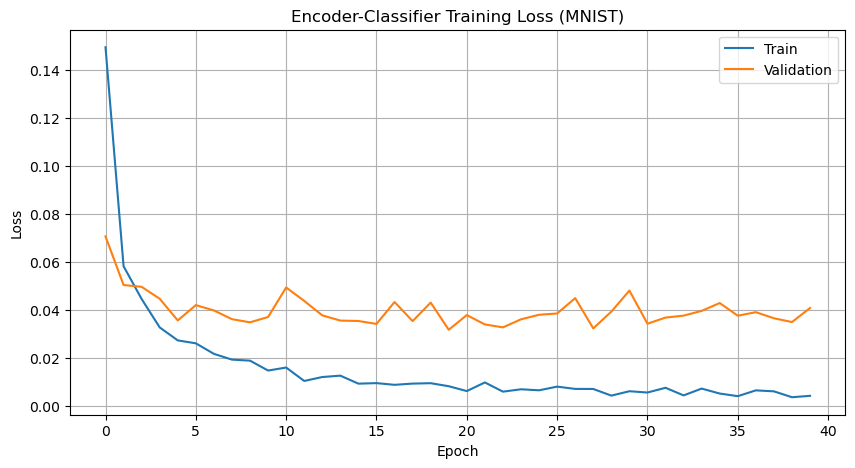

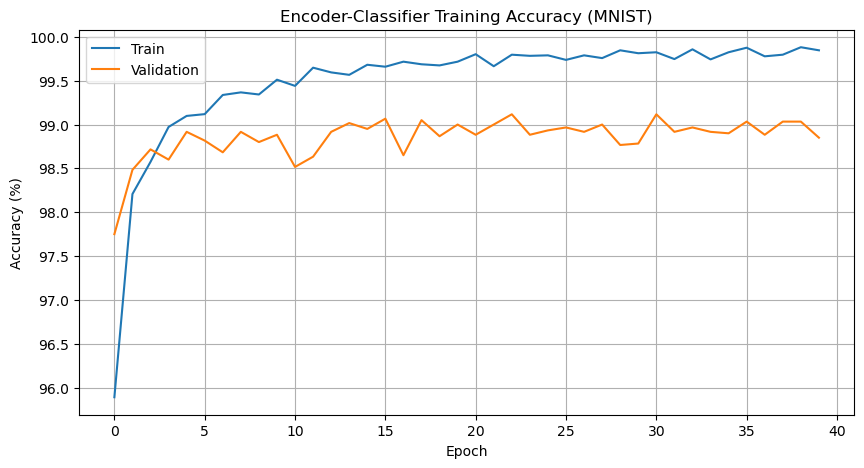

In [9]:
# Cell 9: Train Encoder and Classifier Jointly
print("\n--- Training Encoder and Classifier Jointly ---")
encoder_classifier, train_losses, train_accuracies, val_losses, val_accuracies = train_encoder_classifier(
    encoder_classifier, train_loader, val_loader, EPOCHS, device,
    lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Plot training curves
plot_training_curve(
    train_losses, val_losses,
    f'Encoder-Classifier Training Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'encoder_classifier_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

plot_training_curve(
    train_accuracies, val_accuracies,
    f'Encoder-Classifier Training Accuracy ({("MNIST" if use_mnist else "CIFAR10")})',
    'Accuracy (%)',
    save_path=f'encoder_classifier_accuracy_{("mnist" if use_mnist else "cifar10")}.png'
)

In [10]:
# New cell between 9 and 10: Define custom t-SNE plotting function
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def custom_plot_tsne(model, dataloader, device):
    """
    Custom t-SNE plotting function with all necessary imports included.
    """
    model.eval()
    
    images_list = []
    labels_list = []
    latent_list = []
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Get latent representation
            latent_vector = model(images)
            
            images_list.append(images.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            latent_list.append(latent_vector.cpu().numpy())
            
            # Limit samples to speed up computation
            if i >= 10:
                break
    
    images = np.concatenate(images_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    latent_vectors = np.concatenate(latent_list, axis=0)
    
    # Plot TSNE for latent space
    tsne_latent = TSNE(n_components=2, random_state=0)
    latent_tsne = tsne_latent.fit_transform(latent_vectors)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE of Latent Space')
    plt.grid(True)
    plt.savefig('latent_tsne.png')
    plt.show()
    
    # Plot image domain tsne
    tsne_image = TSNE(n_components=2, random_state=42)
    images_flattened = images.reshape(images.shape[0], -1)
    image_tsne = tsne_image.fit_transform(images_flattened)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(image_tsne[:, 0], image_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE of Image Space')
    plt.grid(True)
    plt.savefig('image_tsne.png')
    plt.show()


--- Evaluating Model ---


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 32.41it/s]


Test Accuracy: 98.96%

--- Computing t-SNE Visualization ---


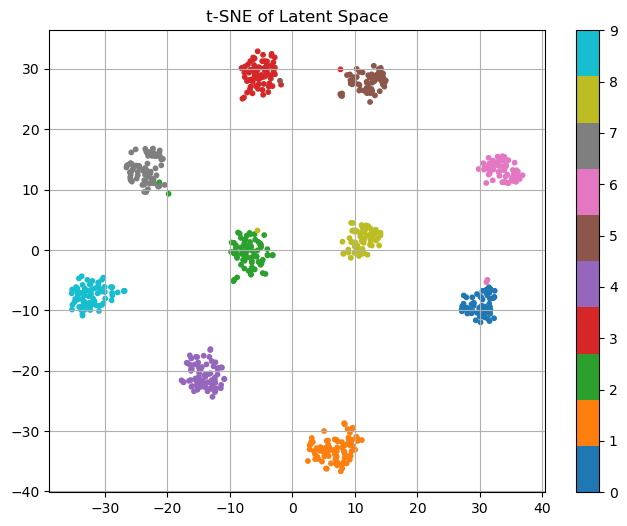

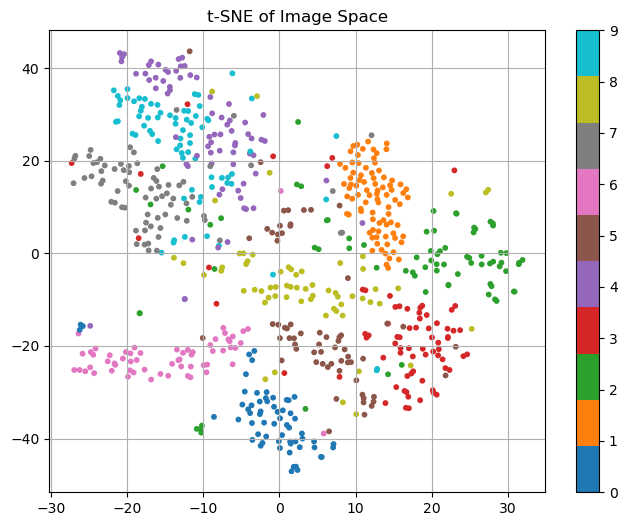


--- Summary ---
Dataset: MNIST
Latent Dimension: 128
Final Train Loss: 0.004302
Final Train Accuracy: 99.85%
Final Validation Loss: 0.040862
Final Validation Accuracy: 98.85%
Test Accuracy: 98.96%


In [11]:
# Cell 10: Evaluate Model and Visualize t-SNE
# Evaluate on test set
print("\n--- Evaluating Model ---")
test_accuracy = evaluate_model(encoder_classifier, test_loader, device)

# Plot t-SNE visualization using our custom function
print("\n--- Computing t-SNE Visualization ---")
custom_plot_tsne(encoder, test_loader, device)  # Use custom function instead

# Print summary
print("\n--- Summary ---")
print(f"Dataset: {('MNIST' if use_mnist else 'CIFAR10')}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")